In [1]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import imageio


from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce


try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

In [2]:
import math 
import torch
from torch import sigmoid
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.normal import Normal

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + torch.mul(self.sigma, self.sample_epsilon()) # <- your code
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        n = torch.distributions.normal.Normal(self.mu, self.sigma)
        return n.log_prob(z) # <- your code

>> Using device: cuda:0


In [3]:
import os
os.chdir('C:/Users/Bruger/Desktop/courses/deep learning 2020/9-project')
import logitmixture

In [4]:
import os
filepath='C:/Users/Bruger/Desktop/courses/deep learning 2020/9-project'
os.chdir(filepath)

trainset=torch.load('cifar_train')
testset=torch.load('cifar_test')


#Choose the batch_size

batchs=50


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchs,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchs,shuffle=True)

In [5]:
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

In [6]:
#plot a few MNIST examples
#f, axarr = plt.subplots(4, 4, figsize=(16, 16))

# Load a batch of images into memory
images, images_ta = next(train_data_iter)
"""
for i, ax in enumerate(axarr.flat):
    ax.imshow(np.transpose(images[i,:,:,:], (1, 2, 0)))
    ax.axis('off')
    
plt.suptitle('CIFAR Batch')
plt.show()
"""

"\nfor i, ax in enumerate(axarr.flat):\n    ax.imshow(np.transpose(images[i,:,:,:], (1, 2, 0)))\n    ax.axis('off')\n    \nplt.suptitle('CIFAR Batch')\nplt.show()\n"

In [7]:
"""
f, axarr = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in enumerate(axarr.flat):
    ax.imshow(np.transpose(images_ta[i,:,:,:], (1, 2, 0)))
    ax.axis('off')
    
plt.suptitle('CIFAR Batch targets')
plt.show()
"""

"\nf, axarr = plt.subplots(4, 4, figsize=(16, 16))\n\nfor i, ax in enumerate(axarr.flat):\n    ax.imshow(np.transpose(images_ta[i,:,:,:], (1, 2, 0)))\n    ax.axis('off')\n    \nplt.suptitle('CIFAR Batch targets')\nplt.show()\n"

## Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation.

In [8]:
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, Upsample
from torch.nn.functional import relu, elu, relu6, tanh, softmax


class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int, batch_size:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_1 = Conv2d(in_channels=3,out_channels=64,kernel_size=5,stride=1)
        self.conv_2 = Conv2d(in_channels=64,out_channels=32,kernel_size=5,stride=1)
        self.conv_3 = Conv2d(in_channels=32,out_channels=3,kernel_size=3,stride=1)

        self.conv_4 = Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv_5 = Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding=2)
        self.conv_6 = Conv2d(in_channels=128,out_channels=64,kernel_size=5,stride=1,padding=2)
        self.conv_7 = Conv2d(in_channels=64,out_channels=3,kernel_size=3,stride=1,padding=1)

        
        self.up = Upsample(scale_factor=2, mode='bicubic')
        
        
        self.lin_1 = Linear(in_features=3*8*8, out_features=2*latent_features)
        self.lin_2 = Linear(in_features=latent_features, out_features=3*8*8)
        self.lin_pri = Linear(in_features=3*8*8, out_features=2*latent_features) 

        
    # Inference Network
    # Encode the observation `x` into the parameters of the posterior distribution
    # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
    def encoder(self, x:Tensor):
            
        x = relu(self.conv_1(x))
        x = relu(self.pool(x))
        x = relu(self.conv_2(x))
        x = relu(self.conv_3(x))
        x = x.view(batchs,3*8*8)
        x = relu(self.lin_1(x))

        return x
        
    # Generative Model
    # Decode the latent sample `z` into the parameters of the observation model
    # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
    def decoder(self, x:Tensor):
            
        x = relu(self.lin_2(x))
        x = x.view(batchs,3,8,8)
        x = relu(self.conv_4(x))
        x = relu(self.up(x))
        x = relu(self.conv_5(x))
        x = relu(self.up(x))
        x = relu(self.conv_6(x))
        x = sigmoid(self.conv_7(x))

        return x
    
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, x:Tensor)-> Distribution:
        """return the distribution `p(z)`"""
        x = x.view(batchs,8*8*3)
        x = relu(self.lin_pri(x))
        mu, log_sigma = x.chunk(2, dim=-1)
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        #px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Normal(loc=px_logits,scale=torch.ones(px_logits.shape).to(device)/100)
        #return logitmixture.DiscretizedMixtureLogitsDistribution(nr_mix=batchs,logits=px_logits)
    
    def separate(self, x):
        return x[1],x[0]
        
        
    def forward(self, x) -> Dict[str, Any]:
        #compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)
        x, pz = self.separate(x)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pxfromprior = self.sample_from_prior(pz)
        pz = self.prior(pz)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z, 'pxprior': pxfromprior}
    
    
    def sample_from_prior(self, x:Tensor):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(x)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return px


latent_features = 32
vae = VariationalAutoencoder(images[0].shape, latent_features, batchs)
print(vae)

VariationalAutoencoder(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv_3): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv_4): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_6): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up): Upsample(scale_factor=2.0, mode=bicubic)
  (lin_1): Linear(in_features=192, out_features=64, bias=True)
  (lin_2): Linear(in_features=32, out_features=192, bias=True)
  (lin_pri): Linear(in_features=192, out_features=64, bias=True)
)


## Module for Variational Inference


In [9]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor, mypri:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model((mypri,x))
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["pxprior", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        
        #myrec=outputs['px']
        #x_sample = myrec.sample()


        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl# <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()#+nn.MSELoss()(x,x_sample)
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [10]:
vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae.to(device),images_ta.to(device),images.to(device))
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean = 1034979.188, shape: []
elbo   | mean = -1034979.188, shape: [50]
log_px | mean = -1034978.188, shape: [50]
kl     | mean =      1.035, shape: [50]


C:\Users\Bruger\Anaconda3\lib\site-packages\torch\nn\functional.py:3121: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [11]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 64*3
vae = VariationalAutoencoder(images[0].shape, latent_features,batchs)

# Evaluator: Variational Inference
beta = 0.9
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

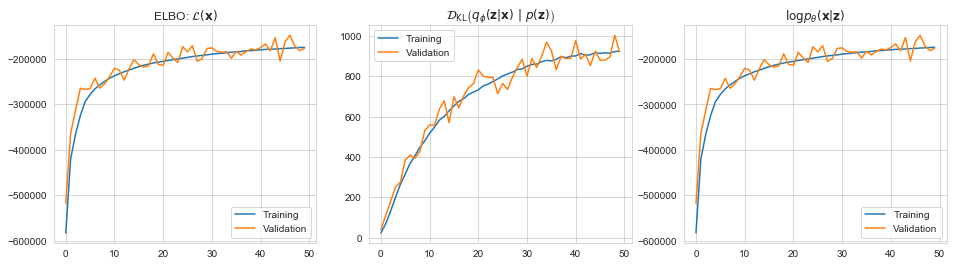

In [12]:
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for y, x in trainloader:
        x = x.to(device)
        y = y.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        y, x = next(iter(testloader))
        x = x.to(device)
        y = y.to(device)
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x, y)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    # plot ELBO
    
    f,axes=plt.subplots(1,3,figsize=(16,4))
    ax = axes[0]
    ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
    ax.plot(training_data['elbo'], label='Training')
    ax.plot(validation_data['elbo'], label='Validation')
    ax.legend()

    # plot KL
    ax = axes[1]
    ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
    ax.plot(training_data['kl'], label='Training')
    ax.plot(validation_data['kl'], label='Validation')
    ax.legend()

    # plot NLL
    ax = axes[2]
    ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
    ax.plot(training_data['log_px'], label='Training')
    ax.plot(validation_data['log_px'], label='Validation')
    ax.legend()
    
    plt.show()
    clear_output(wait=True)


Text(0.5, 1.0, 'Reconstructed from prior')

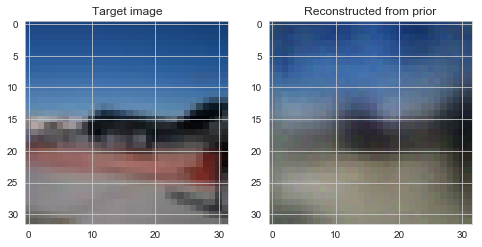

In [13]:
outputs=vae((images.to(device),images_ta.to(device)))
idx=2


myim=images_ta[idx,:,:,:].numpy()

myrec=outputs['pxprior']
x_sample = myrec.sample().to('cpu')
x_sample=x_sample.numpy()

f,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(np.transpose(myim, (1, 2, 0)))
ax[0].set_title('Target image')
ax[1].imshow(np.transpose(x_sample[idx,:,:,:], (1, 2, 0)))
ax[1].set_title('Reconstructed from prior')

In [14]:

testloader = torch.utils.data.DataLoader(testset, batch_size=batchs,shuffle=False)
images,images_ta=next(iter(testloader))

In [15]:
mylosses=[]
for y,x in testloader:
    outputs=vae((y.to(device),x.to(device)))
    myrec=outputs['pxprior']
    x_sample = myrec.sample()
    mylosses.append(nn.MSELoss()(x.to(device),x_sample))
        
lo=np.sum(mylosses)/len(mylosses)
print(lo)

tensor(0.0122, device='cuda:0')


In [57]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batchs,shuffle=False)
test_data_iter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed from prior')

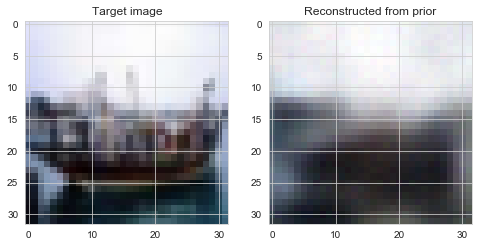

In [58]:
y,x = next(test_data_iter)

outputs=vae((y.to(device),x.to(device)))

idx=18


myim=x[idx,:,:,:].numpy()

myrec=outputs['pxprior']
x_sample = myrec.sample().to('cpu')
x_sample=x_sample.numpy()

f,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(np.transpose(myim, (1, 2, 0)))
ax[0].set_title('Target image')
ax[1].imshow(np.transpose(x_sample[idx,:,:,:], (1, 2, 0)))
ax[1].set_title('Reconstructed from prior')

In [36]:
y,x = testset[6694]
ybis,xbis = testset[2]
yb=torch.stack((y,ybis),dim=0)
xb=torch.stack((x,xbis),dim=0)

y=torch.stack((y,testset[2][0],testset[3][0],testset[4][0],testset[5][0],testset[6][0],testset[7][0],testset[8][0],
               testset[9][0],testset[10][0],testset[11][0],testset[12][0],testset[13][0],testset[14][0],
               testset[15][0],testset[16][0]), dim=0)
x=torch.stack((x,testset[2][1],testset[3][1],testset[4][1],testset[5][1],testset[6][1],testset[7][1],testset[8][1],
               testset[9][1],testset[10][1],testset[11][1],testset[12][1],testset[13][1],testset[14][1],
               testset[15][1],testset[16][1]), dim=0)

x.shape


torch.Size([16, 3, 32, 32])

In [37]:
y=torch.cat((y,y,y,yb),dim=0)
x=torch.cat((x,x,x,xb),dim=0)
x.shape

torch.Size([50, 3, 32, 32])

In [38]:
y.shape

torch.Size([50, 3, 8, 8])

Text(0.5, 1.0, 'Reconstructed from prior')

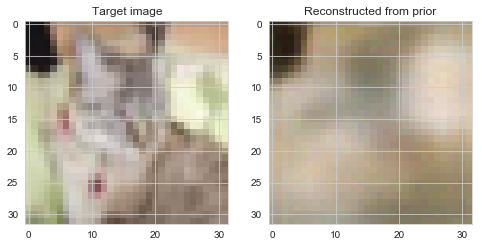

In [47]:
outputs=vae((y.to(device),x.to(device)))

idx=7


myim=x[idx,:,:,:].numpy()

myrec=outputs['pxprior']
x_sample = myrec.sample().to('cpu')
x_sample=x_sample.numpy()

f,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(np.transpose(myim, (1, 2, 0)))
ax[0].set_title('Target image')
ax[1].imshow(np.transpose(x_sample[idx,:,:,:], (1, 2, 0)))
ax[1].set_title('Reconstructed from prior')

In [15]:
myim=testset[18]

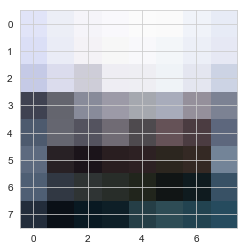

In [16]:
plt.figure()
plt.imshow(np.transpose(myim[0],(1,2,0)))